In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# pip install openpyxl
# pip install lifeines

from sksurv.ensemble import RandomSurvivalForest
from sklearn.inspection import permutation_importance
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored


# Load the Excel file and convert to CSV
df = pd.read_excel("../Data/RADCURE_Clinical_v04_20241219.xlsx")  # Use 'openpyxl' for .xlsx files
df.to_csv("../Data/RADCURE_Clinical_v04_20241219.csv", index=False)  # index=False prevents adding an extra index column
print(f"Excel file 'RADCURE_Clinical_v04_20241219.xlsx' converted to CSV as 'RADCURE_Clinical_v04_20241219.csv'")



# 1. Load the dataset
cancer_clinical_cia = pd.read_csv('../Data/RADCURE_Clinical_v04_20241219.csv') # Head and Neck cancer clinical data from the Cancer Imaging Archive

# 2. Examine the Dataset: Investigate the dataset before cleaning to find NA values, duplicates, etc.
print(cancer_clinical_cia.head()) 
cancer_clinical_cia.info() # columns 24-31 have a high number of NA values
print(cancer_clinical_cia.shape) #dimensions
# print(cancer_clinical_cia.describe()) # mean age is ~60
# cancer_clinical_cia.tail()
# print(cancer_clinical_cia.columns)
# cancer_clinical_cia.dtypes # dtypes: float64(3), int64(2), object(29)



print(cancer_clinical_cia.isnull().sum())  # Missing values

# plot to understand dataset key features
# sns.histplot(df["Age"], bins=20, kde=True)
# plt.title("Age Distribution")
# plt.show()

# sns.countplot(x="Stage", data=df)
# plt.title("Tumor Stage Distribution")
# plt.show()

# sns.countplot(x="Tx Modality", data=df)
# plt.title("Treatment Type Distribution")
# plt.show()


# Subset of the relevant columns for the analysis
relevant_columns = ['patient_id', 'Age', 'Sex', 'ECOG PS', 'Smoking PY', 'Smoking Status', 'Stage', 'Tx Modality', 'Status' ,'Length FU']
df_subset = cancer_clinical_cia[relevant_columns]


# Convert 'Smoking PY' to numeric, forcing errors to NaN
df_subset['Smoking PY'] = pd.to_numeric(df_subset['Smoking PY'], errors='coerce')

# Fill missing values with the median of the column
df_subset['Smoking PY'] = df_subset['Smoking PY'].fillna(df_subset['Smoking PY'].median())

# For 'ECOG PS', fill missing values with the mode
df_subset['ECOG PS'] = df_subset['ECOG PS'].fillna(df_subset['ECOG PS'].mode()[0])



# Event indicator based on 'Status' column (1 = event, 0 = censored)
df_subset['Event'] = df_subset['Status'].apply(lambda x: 1 if x == 'Dead' else 0)

# Survival time (e.g., 'Length FU' or the time between 'Date of Death' and 'Last FU')
df_subset['Survival_Time'] = df_subset['Length FU']  # Assuming 'Length FU' is in days or months




# # Convert categorical variables to numeric using OneHotEncoding
# cat_cols = df.select_dtypes(include=['object']).columns
# df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)


print(df_subset.head())


Excel file 'RADCURE_Clinical_v04_20241219.xlsx' converted to CSV as 'RADCURE_Clinical_v04_20241219.csv'
     patient_id   Age     Sex ECOG PS Smoking PY Smoking Status     Ds Site  \
0  RADCURE-0005  62.6  Female  ECOG 0         50      Ex-smoker  Oropharynx   
1  RADCURE-0006  87.3    Male  ECOG 2         25      Ex-smoker      Larynx   
2  RADCURE-0007  49.9    Male  ECOG 1         15      Ex-smoker  Oropharynx   
3  RADCURE-0009  72.3    Male  ECOG 1         30      Ex-smoker     Unknown   
4  RADCURE-0010  59.7  Female  ECOG 0          0     Non-smoker  Oropharynx   

           Subsite    T    N  ... Local Date Local Regional Date Regional  \
0        post wall  T4b  N2c  ...   NaN        NaN      NaN           NaN   
1          Glottis  T1b   N0  ...   NaN        NaN      NaN           NaN   
2           Tonsil   T3  N2b  ...   NaN        NaN      NaN           NaN   
3              NaN   T0  N2c  ...   NaN        NaN      NaN           NaN   
4  Tonsillar Fossa  T4b   N0  ...   

C:\Users\rihan\AppData\Local\Temp\ipykernel_50048\180378357.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Smoking PY'] = pd.to_numeric(df_subset['Smoking PY'], errors='coerce')
C:\Users\rihan\AppData\Local\Temp\ipykernel_50048\180378357.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Smoking PY'] = df_subset['Smoking PY'].fillna(df_subset['Smoking PY'].median())
C:\Users\rihan\AppData\Local\Temp\ipykernel_50048\180378357.py:66: SettingWithCopyWarning: 
A value is trying to 

In [195]:
# # print(df.head()) 
# print(df_encoded['Tx Modality'].unique())
# print(df_encoded['Tx Modality'].isnull().sum()) 

# print(df['Sex'].unique())
# print(df_encoded.columns)

C:\Users\rihan\AppData\Local\Temp\ipykernel_50048\2003692254.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Tx Group'] = df_subset['Tx Modality'].apply(lambda x: 'RT_alone' if x == 'RT_alone' else ('ChemoRT' if x == 'ChemoRT' else 'Other'))


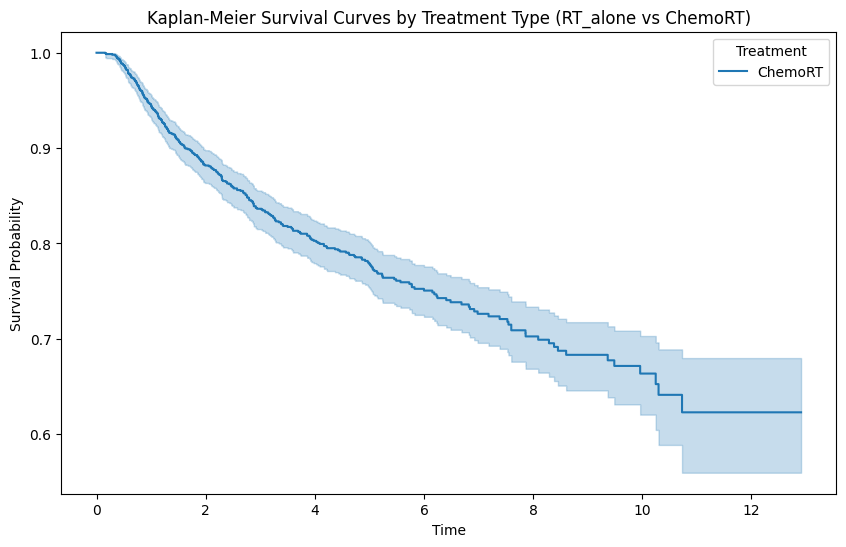

Log-rank test p-value: nan


In [196]:
# Build and Evaluate Models
# 1. Kaplan-Meier Analysis ------------------

# Select 2 treatment types (RT_alone and ChemoRT)
df_subset['Tx Group'] = df_subset['Tx Modality'].apply(lambda x: 'RT_alone' if x == 'RT_alone' else ('ChemoRT' if x == 'ChemoRT' else 'Other'))

kmf = KaplanMeierFitter()

# Kaplan-Meier fit by Tumor stages and plot survival curves
plt.figure(figsize=(10, 6))
for group in df_subset['Tx Group'].unique():
    if group in ['RT_alone', 'ChemoRT']:  # Only plot for RT_alone and ChemoRT
        group_data = df_subset[df_subset['Tx Group'] == group]
        kmf.fit(group_data['Survival_Time'], event_observed=group_data['Event'], label=group)
        kmf.plot()

plt.title("Kaplan-Meier Survival Curves by Treatment Type (RT_alone vs ChemoRT)")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend(title='Treatment')
plt.show()

# Log-rank test for the two treatments
rt_alone = df_subset[df_subset['Tx Group'] == 'RT_alone']
chemoRT = df_subset[df_subset['Tx Group'] == 'ChemoRT']

# Perform the log-rank test
logrank_results = logrank_test(rt_alone['Survival_Time'], chemoRT['Survival_Time'], 
                               event_observed_A=rt_alone['Event'], event_observed_B=chemoRT['Event'])

# Print the log-rank test p-value to check for significant differences
print("Log-rank test p-value:", logrank_results.p_value)



In [197]:
# # 2. Cox Proportional Hazards Regression

from sklearn.preprocessing import LabelEncoder

# Encode 'Sex' as numeric (Male = 1, Female = 0)
label_encoder = LabelEncoder()
df_subset['Sex'] = label_encoder.fit_transform(df_subset['Sex'])

# Replace 'na' with NaN (Not a Number) in the dataframe
df_subset.replace('na', pd.NA, inplace=True)
# print(df_subset.isna().sum())


# Drop rows with missing values in key columns
df_subset = df_subset.dropna(subset=['Survival_Time', 'Event', 'Age', 'Sex', 'Smoking PY'])

# Subset only relevant columns for the Cox model (no need for other columns)
df_subset_cox = df_subset[['Survival_Time', 'Event', 'Age', 'Sex', 'Smoking PY']]  # Adjust to include only necessary columns


# Verify the columns are numeric and properly encoded
# print(df_subset[['Age', 'Sex', 'Smoking PY']].head()) 


# Create age bins as per cox recommendation
bins = [0, 30, 40, 50, 60, 70, 80, 90, 100]  # Adjust bin edges as needed
labels = ['0-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
df_subset_cox['Age_binned'] = pd.cut(df_subset_cox['Age'], bins=bins, labels=labels, right=False)
# Map the binned age categories to numeric values
age_bin_mapping = {
    '0-30': 1,
    '31-40': 2,
    '41-50': 3,
    '51-60': 4,
    '61-70': 5,
    '71-80': 6,
    '81-90': 7,
    '91-100': 8
}
df_subset_cox['Age_binned_numeric'] = df_subset_cox['Age_binned'].map(age_bin_mapping)

# Drop the 'Age_binned' column after creating the 'Age_binned_numeric' column
df_subset_cox.drop(columns=['Age_binned'], inplace=True)
print(df_subset_cox.head())



# Covariates - select 3 
covariates = ['Age_binned_numeric', 'Sex', 'Smoking PY']
covariates = ['Age_binned', 'Sex', 'Smoking PY']

cph = CoxPHFitter()
# cph.fit(df_subset_cox[['Survival_Time', 'Event'] + covariates], duration_col='Survival_Time', event_col='Event')
cph.fit(df_subset_cox, duration_col='Survival_Time', event_col='Event')

# Print Cox model summary
cph.print_summary()

# validate
cph.check_assumptions(df_subset_cox, p_value_threshold=0.05)



C:\Users\rihan\AppData\Local\Temp\ipykernel_50048\1527706610.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Sex'] = label_encoder.fit_transform(df_subset['Sex'])
C:\Users\rihan\AppData\Local\Temp\ipykernel_50048\1527706610.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.replace('na', pd.NA, inplace=True)
C:\Users\rihan\AppData\Local\Temp\ipykernel_50048\1527706610.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

   Survival_Time  Event   Age  Sex  Smoking PY Age_binned_numeric
0       1.317808      1  62.6    0        50.0                  5
1       1.520548      1  87.3    1        25.0                  7
2       2.126027      0  49.9    1        15.0                  3
3       5.791781      0  72.3    1        30.0                  6
4       9.512329      0  59.7    0         0.0                  4


<lifelines.CoxPHFitter: fitted with 3346 total observations, 2288 right-censored observations>
             duration col = 'Survival_Time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 3346
number of events observed = 1058
   partial log-likelihood = -7793.13
         time fit was run = 2025-03-14 16:33:39 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
Age                 0.03      1.04      0.01            0.01            0.06                1.01                1.06
Sex                -0.06      0.94      0.08           -0.21            0.09                0.81                1.10
Smoking PY          0.01      1.01      0.00            0.01            0.01                1.01                1.01
Age_binned_numeric  0.02      1.02      0.11           -0.19            0.23                0.83                1.26

                    cmp to     z      p  -log2(p)
covariate                                        
Age                   0.00  3.17 <0.005      9.34
Sex                   0.00 -0.78   0.43      1.20
Smoking PY            0.00 11.25 <0.005     95.09
Age_binned_numeric    0.00  0.22   0.83      0.27
---
Concordance = 0.65
Partial AIC = 15594.26
log-likelihood ratio test = 356.11 on 4 df
-log2(p) of ll-ratio test = 249.40

Proportional hazard assumption looks okay.


[]

In [198]:
# 3. Random Survival Forests (RSF)
# One-hot encode categorical variables like 'Stage', 'Sex', and 'Smoking Status'
df_sub_encoded = pd.get_dummies(df_subset, columns=['Stage', 'Smoking Status'], drop_first=True)

# Prepare data for RSF
X = df_sub_encoded[['Age', 'Sex', 'Smoking PY', 'ECOG PS', 'Smoking Status'] + list(df_sub_encoded.columns[df_sub_encoded.columns.str.startswith('Stage')])]
y = Surv.from_dataframe('Event', 'Survival_Time', df_subset)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train RSF model
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, random_state=42)
rsf.fit(X_train, y_train)

# Feature Importance
importances = pd.Series(rsf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.plot(kind='bar')
plt.title("Feature Importance in RSF")
plt.show()


# Comparison of Models (C-Index)

# Calculate C-index for RSF
c_index_rsf = concordance_index_censored(y_test['Event'], y_test['Survival_Time'], rsf.predict(X_test))[0]

# Calculate C-index for Cox model
c_index_cox = cph.concordance_index_

print(f"Cox Proportional Hazards C-index: {c_index_cox:.3f}")
print(f"Random Survival Forest C-index: {c_index_rsf:.3f}")

KeyError: "['Smoking Status'] not in index"